In [1]:
# Set the path
import sys
sys.path.append("../../")

from act.cell_model import ACTCellModel
from act.simulator import ACTSimulator
from act.types import SimulationParameters, ConstantCurrentInjection, RampCurrentInjection
import act.data_processing as dp

import numpy as np
import matplotlib.pyplot as plt

from act.passive import ACTPassiveModule
from act.segregation import ACTSegregator

from sklearn.metrics import mean_absolute_error
from act.metrics import summary_features_error
import shutil

--No graphics will be displayed.


### Generate target data

In [2]:
# Define the "target" cell
target_cell = ACTCellModel(
    cell_name = "BursterCa",
    path_to_hoc_file = "../../data/BursterCa/orig/template.hoc",
    path_to_mod_files = "../../data/BursterCa/orig/modfiles/",
    passive = ["gbar_leak", "eleak"],
    active_channels = ["gbar_na", "gbar_kdr", "gbar_cas", "gbar_ka", "gbar_kca", "gbar_cat"],
)

In [3]:
# Set simulations
simulator = ACTSimulator(output_folder_name = "output")

for amp_idx, amp in enumerate([0, 0.5, 1.0]):
    sim_params = SimulationParameters(
        sim_name = "target",
        sim_idx = amp_idx,
        h_celsius = 37,
        h_dt = 0.1,
        h_tstop = 1000,
        h_v_init = -40,
        CI = [ConstantCurrentInjection(amp = amp, dur = 700, delay = 100)]
        )

    simulator.submit_job(target_cell, sim_params)
    
simulator.run_jobs(3)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


In [4]:
dp.combine_data("output/target")

output/target/combined_out.npy


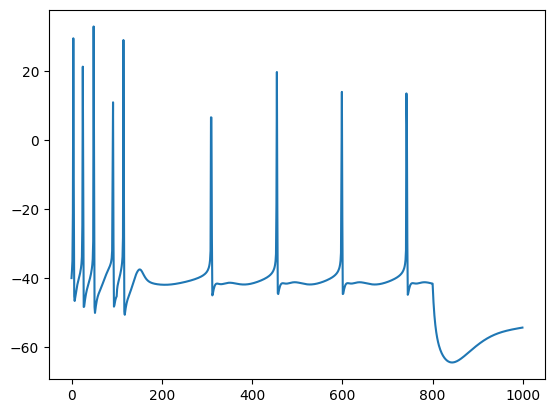

In [5]:
passive_trace = np.load("output/target/out_2.npy")[:, 0]
plt.plot(passive_trace[::10])

In [6]:
# Compute the error with respective target summary features
data = np.load(f"output/target/combined_out.npy")
V = data[:, ::10, 0].reshape((3, -1))
I = data[:, ::10, 1].reshape((3, -1))
summary_features_target = dp.get_summary_features(V, I, window = (100, 800))

In [7]:
# LTO: NaP, KM

def modify_template(spiking_th, bursting_th):
    
    spiking = [
        ("na.mod", 57, spiking_th), 
        ("kdr.mod", 53, spiking_th)
    ]
    bursting = [
        ("cat.mod", 56, bursting_th), 
        ("cas.mod", 60, bursting_th),
        ("ka.mod", 58, bursting_th),
        ("kca.mod", 57, bursting_th)
    ]

    for entry in spiking + bursting:
        with open(f"../../data/BursterCa/orig_cutoff_test/modfiles/{entry[0]}", "r") as file:
            mod_file = file.readlines()

            sign = '<'
            mod_file[entry[1]] = "\t" + f"if (v {sign} {entry[2]}) " + "{\n"

        with open(f"../../data/BursterCa/orig_cutoff_test/modfiles/{entry[0]}", "w") as file:
            file.writelines(mod_file)

In [8]:
modify_template(-2, -1)

# Experiment

In [9]:
import os

def run_eval_single_simulation(current_injection, summary_features_target):

    assert len(current_injection) == 3

    # Define the cell
    cell = ACTCellModel(
        cell_name = "BursterCa",
        path_to_hoc_file = "../../data/BursterCa/orig_cutoff_test/template.hoc",
        path_to_mod_files = "../../data/BursterCa/orig_cutoff_test/modfiles/",
        passive = ["gbar_leak", "eleak"],
        active_channels = ["gbar_na", "gbar_kdr", "gbar_cas", "gbar_ka", "gbar_kca", "gbar_cat"],
    )

    # Set simulations
    simulator = ACTSimulator(output_folder_name = "output")

    for inj_id, inj in enumerate(current_injection):
        sim_params = SimulationParameters(
            sim_name = "sim",
            sim_idx = inj_id,
            h_celsius = 37,
            h_dt = 0.1,
            h_tstop = 1000,
            h_v_init = -40,
            CI = [inj])

        simulator.submit_job(cell, sim_params)

    simulator.run_jobs(3)
    dp.combine_data("output/sim")

    # Get summary features
    data = np.load(f"output/sim/combined_out.npy")
    V = data[:, ::10, 0].reshape((3, -1))
    I = data[:, ::10, 1].reshape((3, -1))
    summary_features = dp.get_summary_features(V, I, window = (100, 800))

    # Clean
    shutil.rmtree("output/sim")

    return np.nanmean(summary_features_error(summary_features_target.to_numpy(), summary_features.to_numpy()))

In [10]:
# V-rest ~-70
all_errors = np.zeros(
    (
        len(np.arange(-80, 10, 5)), # Spiking
        len(np.arange(-80, 10, 5)) # Bursting
    )
) * np.nan

In [11]:
all_errors.shape

(18, 18)

In [12]:
for idx_1, spiking_bound in enumerate(np.arange(-80, 10, 5)):
    for idx_2, bursting_bound in enumerate(np.arange(-80, 10, 5)):
            # Set the bounds
            modify_template(spiking_th = spiking_bound, bursting_th = bursting_bound)
            
            # Run a simulation with constant current injection
            error_const = run_eval_single_simulation(
                [
                    ConstantCurrentInjection(amp = 0, dur = 700, delay = 100),
                    ConstantCurrentInjection(amp = 0.5, dur = 700, delay = 100),
                    ConstantCurrentInjection(amp = 1.0, dur = 700, delay = 100)
                ],
                summary_features_target
                )

            all_errors[idx_1, idx_2] = error_const
            
np.savetxt("all_errors.txt", all_errors)


        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        
output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy

        ACTSimulator (2025)
        ----------
        When submitting multiple jobs, note that the cells must share modfiles.
        


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


output/sim/combined_out.npy


/home/ubuntu/ACT/act/metrics.py:48: RuntimeWarning: Mean of empty slice
  z_mean = np.nanmean(sf_pred, axis = 0)
/home/ubuntu/act-venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/ACT/act/metrics.py:50: RuntimeWarning: invalid value encountered in divide
  sf_pred = (sf_pred - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: divide by zero encountered in divide
  sf_target = (sf_target - z_mean) / z_std
/home/ubuntu/ACT/act/metrics.py:53: RuntimeWarning: invalid value encountered in divide
  sf_target = (sf_target - z_mean) / z_std


In [13]:
all_errors = np.loadtxt("all_errors.txt")

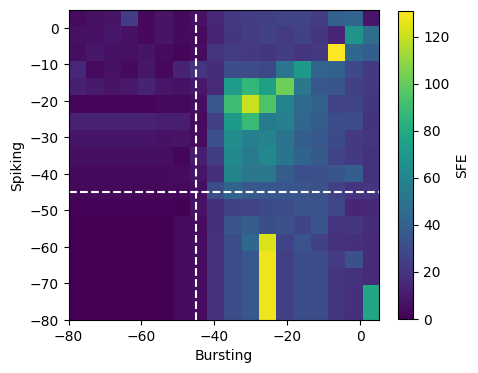

In [14]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))

im = ax.imshow(all_errors, origin = 'lower', extent = [-80, 5, -80, 5])

ax.set_xlabel("Bursting")
ax.set_ylabel("Spiking")

# ax.set_xticks(np.arange(18))
# ax.set_yticks(np.arange(18))
# ax.set_xticklabels(np.arange(-80, 10, 5))
# ax.set_yticklabels(np.arange(-80, 10, 5))

cbar = fig.colorbar(im, shrink = 0.8)
cbar.ax.set_ylabel("SFE")

#eleak_pos = np.arange(18)[np.arange(-80, 10, 5) == -50]
ax.axhline(-45, color = "white", ls = '--')
ax.axvline(-45, color = "white", ls = '--')
# ax.scatter(eleak_pos, eleak_pos, marker = "x", color = 'white', label = "Target") # E-Leak

In [15]:
fig.savefig("BursterCA-segregation_sweeps.png", bbox_inches = "tight", dpi = 500, format = "png")